In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# native
import sys
import os
from os import listdir
from collections import defaultdict
from PIL import Image
import pprint as pp
import functools
import pickle
import re

# math
import numpy as np
from sklearn.metrics import accuracy_score

# plotting
import matplotlib
from matplotlib import pyplot as plt

# extra
from tqdm import tqdm
import logging

# pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


In [2]:
requirements = {
    torch: '1',
    matplotlib: '3'
}

def check_requirements(requirements):
    for requirement in requirements:
        error_message = '{} environment does not match requirement'.format(requirement.__name__)
        assert (requirement.__version__[0] == requirements[requirement]), error_message

check_requirements(requirements)

In [3]:
cuda = torch.cuda.is_available()

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = 'cuda' if cuda else 'cpu'

device

'cuda'

In [4]:
class PlotGrid:
    def __init__(self, figsize=None):
        self.fig = plt.figure(figsize=figsize)
        self.ax = {}
        self.xlim = {}
        self.ylim = {}
        self.filled = {}
        self.grid = {}
    
    def plot(self, position_id, data, title=None, xlim=None, ylim=None, filled=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if xlim is not None:
            self.xlim[position_id] = xlim

        if ylim is not None:
            self.ylim[position_id] = ylim

        if filled is not None:
            self.filled[position_id] = filled
        
        if position_id not in self.filled:
            self.filled[position_id] = True

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        if type(data).__name__ == 'Image':
            ax.imshow(data)
        else:
            if hasattr(data, 'is_cuda') and data.is_cuda:
                data = data.cpu()
            if hasattr(data, 'numpy'):
                data = data.numpy()
            ax.plot(data)

            if self.filled[position_id]:
                ax.fill_between(range(len(data)), data)

            if self.grid[position_id]:
                ax.grid(True)

            # set xlim
            if position_id in self.xlim:
                ax.set_xlim(*self.xlim[position_id])

            # set ylim
            if position_id in self.ylim:
                ax.set_ylim(*self.ylim[position_id])
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def prediction_plot(self, position_id, data, title=None, grid=None):
        if position_id in self.ax:
            ax = self.ax[position_id]
        else:
            ax = self.fig.add_subplot(*position_id)

        # cache current values
        if title is None:
            title = ax.get_title()

        if grid is not None:
            self.grid[position_id] = grid
        
        if position_id not in self.grid:
            self.grid[position_id] = True

        ax.cla()
        ax.clear()
        plot_data = data[2]
        plot_labels = data[1]
        if hasattr(plot_data, 'is_cuda') and plot_data.is_cuda:
            plot_data = plot_data.cpu()
        if hasattr(plot_data, 'numpy'):
            plot_data = plot_data.numpy()

        ticks = range(len(plot_data)-1, -1, -1)

        ax.barh(ticks, plot_data, align='center')

        if self.grid[position_id]:
            ax.grid(True)

        # set xlim
        ax.set_xlim(0, 1)

        # set y labels
        ax.set_yticks(ticks)
        ax.set_yticklabels(plot_labels)
        
        # set title
        if title is not None:
            ax.set_title(title)

        self.fig.tight_layout()
        self.fig.canvas.draw()
        self.ax[position_id] = ax
    
    def savefig(self, filename):
        figure_directory = os.path.join('results', 'activation-plots')
        os.makedirs(figure_directory, exist_ok=True)
        figure_path = os.path.join(figure_directory, filename)
        self.fig.savefig(figure_path, bbox_inches='tight')


In [5]:
def pathJoin(*args):
    return os.path.abspath(os.path.join(*args))


def pprint(*args):
    pp.pprint(*args)


def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))


def smooth(x, span=10):
    return [ np.mean(x[i:i+span]) for i in range(len(x) - span + 1)]


toPILImage = transforms.ToPILImage()

softmax = torch.nn.Softmax(dim=1)


In [6]:
class BaseDataset(Dataset):

    def __init__(self, directory, split='train', transforms=None):
        self.datapoints = defaultdict(list)
        self.split = split
        self.directory = pathJoin(directory, split)
        self.datapoints, self.groundtruths = self.loadDataset()
        self.transforms = transforms

    def __len__(self):
        return len(self.datapoints)

    def __getitem__(self, idx):
        datapoint = self.loadDatapoint(idx)
        return datapoint

    def loadDatapoint(self, idx):
        raise NotImplementedError('Function "loadDatapoint" is not implemented')

    def loadDataset(self, name):
        raise NotImplementedError('Function "loadDataset" is not implemented')


In [7]:
class TinyImageNetDataset(BaseDataset):

    def __init__(self, directory, split='train', transforms=None):
        super().__init__(directory, split, transforms)
        self.descriptions = self.loadDescriptions()
        self.classes = self.loadClasses()
        self.imagenet_classes = self.loadImageNetClasses()
        self.INDEX_IMAGE = 1
        self.INDEX_TARGET = 4
        self.INDEX_LABEL = 3
        self.INDEX_ORIGINAL_CLASS = 2

    def loadDatapoint(self, idx):
        filepath = self.datapoints[idx]
        if not os.path.isfile(filepath):
            filepath = filepath.replace('.JPEG', '.png')
        image = Image.open(filepath).convert('RGB')
        groundtruth = self.groundtruths[idx]
        if self.transforms:
            image = self.transforms(image)
        return (filepath, image, groundtruth, self.descriptions[groundtruth], self.classes.index(groundtruth))

    def loadDataset(self):
        datapoints = []
        groundtruths = []

        if self.split is 'train':
            class_directories = sorted(os.listdir(self.directory))
            for classname in tqdm(class_directories):
                class_path = pathJoin(self.directory, classname, 'images')
                for filename in os.listdir(class_path):
                    datapoints.append(pathJoin(class_path, filename))
                    groundtruths.append(classname)
        elif self.split is 'val':
            dataset_file_list_filename = 'val_annotations.txt'
            dataset_file_list_path = os.path.join(self.directory, dataset_file_list_filename)

            with open(dataset_file_list_path, 'r') as dataset_file_list_file:
                for line in tqdm(dataset_file_list_file, total=sum(1 for line in open(dataset_file_list_path))):
                    filename, annotation, *_ = line.split('\t')
                    file_path = pathJoin(self.directory, 'images', self.sanitizeFilename(filename))
                    datapoints.append(file_path)
                    groundtruths.append(annotation)

        return datapoints, groundtruths
    
    def sanitizeFilename(self, filename):
        return filename.replace('"', '').strip()

    def loadDescriptions(self):
        descriptions = {}

        descriptions_filename = 'words.txt'
        descriptions_path = pathJoin(self.directory, '..', descriptions_filename)

        with open(descriptions_path, 'r') as descriptions_file:
            for line in descriptions_file:
                line = line.strip()
                description_breakdown = line.split('\t')
                descriptions[description_breakdown[0]] = description_breakdown[1]

        return descriptions

    def loadClasses(self):
        classes = []

        classes_filename = 'wnids.txt'
        classes_path = pathJoin(self.directory, '..', classes_filename)

        with open(classes_path, 'r') as classes_file:
            for line in classes_file:
                classes.append(line.strip())

        return classes

    def loadImageNetClasses(self):
        classes = []

        classes_filename = 'synsets.txt'
        classes_path = pathJoin(self.directory, '..', classes_filename)

        with open(classes_path, 'r') as classes_file:
            for line in classes_file:
                classes.append(line.strip())

        return classes
    
    def imagenetidx2class(self, idx):
        return self.imagenet_classes[idx]
    
    def imagenetidx2label(self, idx):
        return self.descriptions[self.imagenetidx2class(idx)]
    
    def idx2class(self, idx):
        return self.classes[idx]
    
    def idx2label(self, idx):
        return self.descriptions[self.idx2class(idx)]



In [8]:
class DeNormalize(object):
    # Source: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = image.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


In [9]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
IMAGE_SIZE = (64, 64)

imagenet_normalization_values = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = transforms.Normalize(**imagenet_normalization_values)
denormalize = DeNormalize(**imagenet_normalization_values)


def toImage(tensor_image):
    return toPILImage(denormalize(tensor_image))

raw_transforms = transforms.Compose([
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(80),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    normalize
])

tinyimagenet_dataset_path = os.path.join('datasets', 'tiny-imagenet-200')

original_train_dataset = TinyImageNetDataset(tinyimagenet_dataset_path, transforms=train_transforms)#raw_transforms)
original_val_dataset = TinyImageNetDataset(tinyimagenet_dataset_path, split='val', transforms=test_transforms)

original_train_loader = DataLoader(original_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
original_val_loader = DataLoader(original_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8)

stylized_tinyimagenet_dataset_path = os.path.join('datasets', 'stylized-64-tiny-imagenet-200')

stylized_train_dataset = TinyImageNetDataset(stylized_tinyimagenet_dataset_path, transforms=train_transforms)#raw_transforms)
stylized_val_dataset = TinyImageNetDataset(stylized_tinyimagenet_dataset_path, split='val', transforms=test_transforms)

stylized_train_loader = DataLoader(stylized_train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
stylized_val_loader = DataLoader(stylized_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=8)

for dataset, loader in [
    (original_train_dataset, original_train_loader),
    (original_val_dataset, original_val_loader),
    (stylized_train_dataset, stylized_train_loader),
    (stylized_val_dataset, stylized_val_loader)
]:
    print('{} Datapoints in {} Batches'.format(len(dataset), len(loader)))

100%|██████████| 10000/10000 [00:00<00:00, 23092.42it/s]


100000 Datapoints in 1563 Batches
10000 Datapoints in 157 Batches
100000 Datapoints in 1563 Batches
10000 Datapoints in 157 Batches


<IPython.core.display.Javascript object>


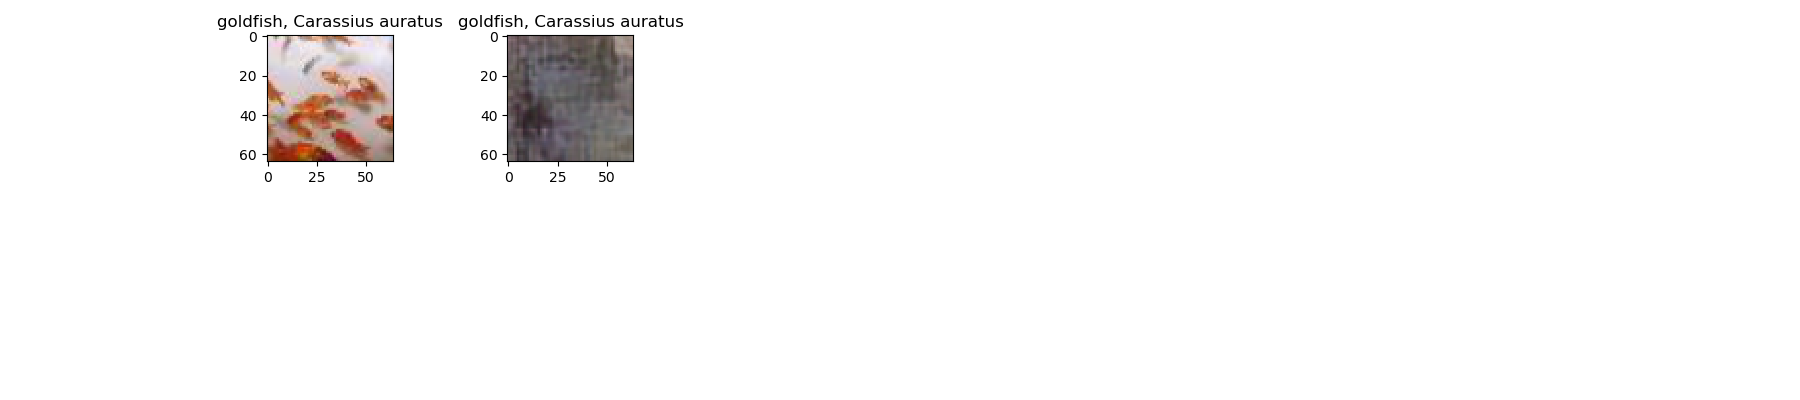

In [10]:
image_grid = PlotGrid(figsize=(9,2))

In [11]:
for index, image in enumerate(original_train_dataset):
    index_image = original_train_dataset.INDEX_IMAGE
    index_label = original_train_dataset.INDEX_LABEL
    
    # get datapoints
    original = original_train_dataset[index]
    stylized = stylized_train_dataset[index]
    
    # get images
    img = original[index_image]
    stylized_img = stylized[index_image]
    
    # plot images
    image_grid.plot((1, 2, 1), toImage(img), title=original[index_label])
    image_grid.plot((1, 2, 2), toImage(stylized_img), title=stylized[index_label])
    if (index + 1) == 9:
        break


In [12]:
# for index, batch in enumerate(miniimagenet_train_loader):
#     img_batch = batch[1]
#     break

In [13]:
# def imshow(img):
#     img = denormalize(img)
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# dataiter = iter(tinyimagenet_train_loader)
# _, images, _, labels, _ = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % labels[j] for j in range(4)))

In [14]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 2)
        self.conv3 = torch.nn.Conv2d(32, 64, 2)
        self.conv4 = torch.nn.Conv2d(64, 64, 1)
        self.conv5 = torch.nn.Conv2d(64, 128, 2)

        self.pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU(inplace=True)

        self.fc1 = torch.nn.Linear(3136, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 200)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 3136)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class VGG_IN(torch.nn.Module):
    def __init__(self, layer_index, pretrained=False):
        super(VGG_IN, self).__init__()
        vgg19 = models.vgg19(pretrained=pretrained)
        self.features1 = vgg19.features[:layer_index]
        self.instance_normalization = torch.nn.InstanceNorm2d(vgg19.features[layer_index].out_channels)
        self.features2 = vgg19.features[layer_index:]
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=2048, out_features=1024, bias=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=1024, out_features=1024, bias=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=1024, out_features=200, bias=True)
        )

    def forward(self, x):
        x = self.features1(x)
        x = self.instance_normalization(x)
        x = self.features2(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class VGG_IN_BS(torch.nn.Module):
    def __init__(self, layer_index, pretrained=False, eps=1e-05):
        super(VGG_IN_BS, self).__init__()
        vgg19 = models.vgg19(pretrained=pretrained)
        self.features1 = vgg19.features[:layer_index]
        self.features2 = vgg19.features[layer_index:]
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=2048, out_features=1024, bias=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=1024, out_features=1024, bias=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=1024, out_features=200, bias=True)
        )
        self.eps = eps

    def forward(self, x):
        x = self.features1(x)
        x_ = x.view(x.size(0), x.size(1), -1)
        mean = x_.mean(2, keepdim=True).unsqueeze(-1)
        std = x_.std(2, keepdim=True).unsqueeze(-1)
        den = torch.sqrt(std.pow(2) + self.eps)
        y = (x - mean)/den
        indices = torch.randperm(x.size(0))
        y = y * std.index_select(0, indices) + mean.index_select(0, indices)
        x = self.features2(y)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [15]:
def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


def create_vgg19_in_pretrained():
    vgg = VGG_IN(21, pretrained=True)
    for param in vgg.features1.parameters():
        param.requires_grad = False
    for param in vgg.features2.parameters():
        param.requires_grad = True #False
    return vgg


def create_vgg19_in_batch_stats_pretrained():
    vgg = VGG_IN_BS(21, pretrained=True)
    for param in vgg.features1.parameters():
        param.requires_grad = False
    for param in vgg.features2.parameters():
        param.requires_grad = True #False
    return vgg


def create_vgg19_pretrained():
    # load model from pytorch
    vgg19 = models.vgg19(pretrained=True)
    # always load in eval mode
    vgg19.eval();

    # freeze cnn layers
    for param in vgg19.parameters():
        param.requires_grad = False

    vgg19.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=2048, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=200, bias=True)
    )
    return vgg19


def create_vgg19_scratch():
    # load model from pytorch
    vgg19 = models.vgg19(pretrained=False)
    # always load in eval mode
    vgg19.eval();

    vgg19.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=2048, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=200, bias=True)
    )
    
    vgg19.apply(init_weights)
    return vgg19


def create_vgg16_pretrained():
    # load model from pytorch
    vgg16 = models.vgg16(pretrained=True)
    # always load in eval mode
    vgg16.eval();

    # freeze cnn layers
    for param in vgg16.parameters():
        param.requires_grad = False

    vgg16.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=2048, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=200, bias=True)
    )

    return vgg16


def create_vgg16_scratch():
    # load model from pytorch
    vgg16 = models.vgg16(pretrained=False)
    # always load in eval mode
    vgg16.eval();

    vgg16.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=2048, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=1024, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(in_features=1024, out_features=200, bias=True)
    )

    vgg16.apply(init_weights)
    return vgg16


def create_cnn():
    return CNN()


# vanilla_vgg19_pretrained = create_vgg19('vanilla', 'all')
# vanilla_vgg19_scratch = create_vgg19('vanilla', 'none')

In [16]:
def score(prediction, target):
    total = prediction.size(0)
    prediction = prediction.t()
    correct = prediction.eq(target.view(1, -1).expand_as(prediction))
    top1 = correct[:1].view(-1).float().sum(0).item()
    top5 = correct[:5].view(-1).float().sum(0).item()
    return top1, top5, total


def score_value(score, total):
    if total > 0:
        return score/total
    else:
        return 0


In [17]:
def validate(model, dataloader, criterion, monitor, logger):
    logger.debug('Validation Start')
    model.eval()
    
    total_top1, total_top5, total_, top1_score, top5_score = 0, 0, 0, 0, 0
    loss = []

#     if monitor:
#         validation_grid = PlotGrid(figsize=(9,3))
#         validation_grid.plot((1, 2, 1), score_value(total_top5, total_), title='Validation Top5 Accuracy', filled=False, ylim=(0,1))

    for batch_index, batch in enumerate(dataloader):
        output = model(batch[dataloader.dataset.INDEX_IMAGE].to(device))
        target = batch[dataloader.dataset.INDEX_TARGET].to(device)

        _, predicted_class = output.topk(5, 1, True, True)
        top1, top5, total = score(predicted_class, target)

        total_top1 += top1
        total_top5 += top5
        total_ += total

        # loss
        batch_loss = criterion(output, target)
        loss.append(batch_loss.item())

#         predicted_descriptions = [ dataloader.dataset.idx2label(x) for x in predicted_class.squeeze() ]

#         if monitor:
#             validation_grid.plot((1, 2, 1), score_value(total_top5, total_), title='Validation Top5 Accuracy {0:.4f}'.format(np.mean(correct)))
#             validation_grid.plot((1, 2, 2), toImage(batch[dataloader.dataset.INDEX_IMAGE][0]), title='True: {}\n Predicted: {}'.format(batch[dataloader.dataset.INDEX_DESCRIPTION][0], predicted_descriptions[0]))

        mean_loss = np.mean(loss)
        top1_score = score_value(total_top1, total_)
        top5_score = score_value(total_top5, total_)
        if (batch_index + 1) % 10 == 0:
            logger.debug('Validation Batch {0}/{1}: Top1 Accuracy {2:.4f} Top5 Accuracy {3:.4f} Loss {4:.4f}'.format(batch_index + 1, len(dataloader), top1_score, top5_score, mean_loss))

    logger.debug('Validation End')
    return top1_score, top5_score, mean_loss

# validate(vanilla_vgg19_pretrained, tinyimagenet_val_loader, monitor=True)

In [18]:
def train(model, dataloader, criterion, optimizer, monitor, logger):
    logger.debug('Training Start')
    model.train()

    if monitor:
        train_grid = PlotGrid(figsize=(9,3))

    total_top1, total_top5, total_, top1_score, top5_score = 0, 0, 0, 0, 0
    loss = []

    for batch_index, batch in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(batch[dataloader.dataset.INDEX_IMAGE].to(device))
        target = batch[dataloader.dataset.INDEX_TARGET].to(device)

        # accuracy
        _, predicted_class = output.topk(5, 1, True, True)
        top1, top5, total = score(predicted_class, target)
#         batch_results = (target == predicted_class.squeeze()).cpu().numpy()
#         accuracy.append(np.mean(batch_results))

        total_top1 += top1
        total_top5 += top5
        total_ += total

        # loss
        batch_loss = criterion(output, target)
        loss.append(batch_loss.item())
        
        # backprop
        batch_loss.backward()
        optimizer.step()
        
        # use mean metrics
        mean_loss = np.mean(loss)
#         mean_accuracy = np.mean(accuracy)
        top1_score = score_value(total_top1, total_)
        top5_score = score_value(total_top5, total_)
        
        # plot
#         if monitor:
#             train_grid.plot((1, 2, 1), smooth(loss, 10), title='Train Loss {0:.4f}'.format(mean_loss), filled=False)
#             train_grid.plot((1, 2, 2), smooth(accuracy, 10), title='Train Accuracy {0:.4f}'.format(mean_accuracy), filled=False, ylim=(0,1))
            
        if (batch_index + 1) % 10 == 0:
            logger.debug('Training Batch {0}/{1}: Top1 Accuracy {2:.4f} Top5 Accuracy {3:.4f} Loss {4:.4f}'.format(batch_index + 1, len(dataloader), top1_score, top5_score, mean_loss))

    logger.debug('Training End')
    return top1_score, top5_score, mean_loss


In [19]:
def run(run_name, model, training, number_of_epochs, monitor, logger, train_loader, val_loader):

    criterion = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=5, min_lr=1e-5, verbose=True)
    
    best_validation_accuracy = 0

    for epoch in range(1, number_of_epochs + 1):
        if training:
            train_top1_accuracy, train_top5_accuracy, train_loss = train(model, train_loader, criterion, optimizer, monitor, logger)
        validation_top1_accuracy, validation_top5_accuracy, validation_loss = validate(model, val_loader, criterion, monitor, logger)
        logger.info('Epoch {0}: Train: Loss: {1:.4f} Top1 Accuracy: {2:.4f} Top5 Accuracy: {3:.4f} Validation: Loss: {4:.4f} Top1 Accuracy: {5:.4f} Top5 Accuracy: {6:.4f}'.format(epoch, train_loss, train_top1_accuracy, train_top5_accuracy, validation_loss, validation_top1_accuracy, validation_top5_accuracy))

        lr_scheduler.step(validation_loss)

        if validation_top5_accuracy > best_validation_accuracy:
            logger.debug('Improved Validation Score, saving new weights')
            model_directory = pathJoin('models')
            os.makedirs(model_directory, exist_ok=True)
            checkpoint = {
                'epoch': epoch,
                'train_top1_accuracy': train_top1_accuracy,
                'train_top5_accuracy': train_top5_accuracy,
                'train_loss': train_loss,
                'validation_top1_accuracy': validation_top1_accuracy,
                'validation_top5_accuracy': validation_top5_accuracy,
                'validation_loss': validation_loss,
                'weights': model.state_dict()
            }
            torch.save(checkpoint, pathJoin(model_directory, '{}.ckpt'.format(run_name)))
            best_validation_accuracy = validation_top5_accuracy
    torch.cuda.empty_cache()

In [20]:
def create_logger(log_directory, filename, stream=False):
    info_filehandler = logging.FileHandler(os.path.join(log_directory, '{}_info.log'.format(filename)))
    debug_filehandler = logging.FileHandler(os.path.join(log_directory, '{}_debug.log'.format(filename)))

    formatter = logging.Formatter('%(asctime)s %(name)s %(levelname)s %(message)s')
    info_filehandler.setFormatter(formatter)
    debug_filehandler.setFormatter(formatter)

    info_filehandler.setLevel(logging.INFO)
    debug_filehandler.setLevel(logging.DEBUG)

    logger = logging.getLogger()
    for hdlr in logger.handlers[:]:
        logger.removeHandler(hdlr)

    if stream:
        streamhandler = logging.StreamHandler(sys.stdout)
        streamhandler.setFormatter(formatter)
        streamhandler.setLevel(logging.DEBUG)
        logger.addHandler(streamhandler)

    logger.addHandler(info_filehandler)
    logger.addHandler(debug_filehandler)

    logger.setLevel(logging.DEBUG)

    logging.getLogger('PIL.PngImagePlugin').setLevel(logging.ERROR)

    return logger


In [21]:
supported_models = {
    'vgg19_in_pretrained_in_tuned_tin': create_vgg19_in_pretrained,
    'vgg19_in_batch_stats_pretrained_in_tuned_tin': create_vgg19_in_batch_stats_pretrained,
    'vgg19_pretrained_in_tuned_tin': create_vgg19_pretrained,
#     'vgg16_pretrained_in_tuned_tin': create_vgg16_pretrained,
    'vgg19_scratch_tin': create_vgg19_scratch,
#     'vgg16_scratch_tin': create_vgg16_scratch,
#     'cnn_tin': create_cnn
}

for model_type in supported_models:
    print(model_type)
    model = supported_models[model_type]()
    for batch in original_train_loader:
        index_image = original_train_loader.dataset.INDEX_IMAGE
        model(batch[index_image].to(device))
        break
    torch.cuda.empty_cache()


vgg19_in_pretrained_in_tuned_tin
vgg19_in_batch_stats_pretrained_in_tuned_tin
vgg19_pretrained_in_tuned_tin
vgg19_scratch_tin


In [22]:
training = True
epochs = 50
monitor = False


# setup log directory
log_directory = pathJoin('run_logs')
os.makedirs(log_directory, exist_ok=True)

for model_type in supported_models:

    # original
    run_name = '{}'.format(model_type)
    logger = create_logger(log_directory, run_name)
    logger.info('Run Name {}'.format(run_name))
    model = supported_models[model_type]()
    run(run_name, model, training, epochs, monitor, logger, original_train_loader, original_val_loader)

    # stylized
    run_name = 'stylized_{}'.format(model_type)
    logger = create_logger(log_directory, run_name)
    logger.info('Run Name {}'.format(run_name))
    model = supported_models[model_type]()
    run(run_name, model, training, epochs, monitor, logger, stylized_train_loader, stylized_val_loader)


Epoch    27: reducing learning rate of group 0 to 2.0000e-03.
Epoch    45: reducing learning rate of group 0 to 4.0000e-04.
Epoch    42: reducing learning rate of group 0 to 2.0000e-03.
Epoch    48: reducing learning rate of group 0 to 4.0000e-04.
Epoch    24: reducing learning rate of group 0 to 2.0000e-03.
Epoch     6: reducing learning rate of group 0 to 2.0000e-03.
Epoch    12: reducing learning rate of group 0 to 4.0000e-04.
Epoch    18: reducing learning rate of group 0 to 8.0000e-05.
Epoch    24: reducing learning rate of group 0 to 1.6000e-05.
Epoch    30: reducing learning rate of group 0 to 1.0000e-05.
Epoch    18: reducing learning rate of group 0 to 2.0000e-03.
Epoch    13: reducing learning rate of group 0 to 2.0000e-03.
Epoch    19: reducing learning rate of group 0 to 4.0000e-04.
Epoch    25: reducing learning rate of group 0 to 8.0000e-05.
Epoch    31: reducing learning rate of group 0 to 1.6000e-05.
Epoch    37: reducing learning rate of group 0 to 1.0000e-05.
Epoch   

In [26]:
def find_normalization_values(dataset, image_index):
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
    all_images = None
    for i in loader:
        all_images = i[image_index]
    mean_image = all_images.mean(0)
    std_image = all_images.std(0)
    mean = mean_image.view(mean_image.size(0), -1).mean(-1)
    std = std_image.view(std_image.size(0), -1).mean(-1)
    return {
        'mean': mean.numpy().tolist(),
        'std': std.numpy().tolist()
    }

# find_normalization_values(miniimagenet_train_dataset, 1)
# find_normalization_values(stylized_miniimagenet_train_dataset, 1)

## Check Performance

In [27]:
def score_model(model, dataloader):
    total_top1 = 0
    total_top5 = 0
    total_ = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            target = batch[dataloader.dataset.INDEX_TARGET].to(device)
            input = batch[dataloader.dataset.INDEX_IMAGE].to(device)
            output = model(input)
            _, predicted_classes = output.topk(5, 1, True, True)
            top1, top5, total = score(predicted_classes, target)
            total_top1 += top1
            total_top5 += top5
            total_ += total
    return total_top1/total_, total_top5/total_


In [31]:
for model_type in supported_models:
    print(model_type)
    model = supported_models[model_type]()
    
#     checkpoint = {
#         'epoch': epoch,
#         'train_accuracy': train_accuracy,
#         'train_loss': train_loss,
#         'validation_accuracy': validation_accuracy,
#         'weights': model.state_dict()
#     }
    checkpoint_path = pathJoin('models', '{}.ckpt'.format(model_type))
#     checkpoint_path = pathJoin('models', 'stylized_{}.ckpt'.format(model_type))
    print(checkpoint_path)
    
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)

        epoch = checkpoint['epoch']
        train_top1_accuracy = checkpoint['train_top1_accuracy']
        train_top5_accuracy = checkpoint['train_top5_accuracy']
        train_loss = checkpoint['train_loss']
        validation_top1_accuracy = checkpoint['validation_top1_accuracy']
        validation_top5_accuracy = checkpoint['validation_top5_accuracy']
        validation_loss = checkpoint['validation_loss']
        model.load_state_dict(checkpoint['weights'])

        model.eval()

        original_top1, original_top5 = score_model(model, original_val_loader)
        stylized_top1, stylized_top5 = score_model(model, stylized_val_loader)
        print('Original: Epoch: {} Top1: {:.4f} Top5: {:.4f}'.format(epoch, original_top1, original_top5))
        print('Stylized: Epoch: {} Top1: {:.4f} Top5: {:.4f}'.format(epoch, stylized_top1, stylized_top5))
        print('Train: Loss: {:.4f} Top1 Accuracy: {:.4f} Top5 Accuracy: {:.4f}'.format(train_loss, train_top1_accuracy, train_top5_accuracy))
        print('Validation: Loss: {:.4f} Top1 Accuracy: {:.4f} Top5 Accuracy: {:.4f}'.format(validation_loss, validation_top1_accuracy, validation_top5_accuracy))
    else:
        print('Checkpoint not available for model {}'.format(model_type))
    torch.cuda.empty_cache()


vgg19_in_pretrained_in_tuned_tin
/var/scratch/grahman/unn/models/vgg19_in_pretrained_in_tuned_tin.ckpt


100%|██████████| 157/157 [00:11<00:00, 15.85it/s]


Original: Epoch: 50 Top1: 0.5912 Top5: 0.7998
Stylized: Epoch: 50 Top1: 0.0060 Top5: 0.0301
Train: Loss: 1.6497 Top1 Accuracy: 0.6165 Top5 Accuracy: 0.7977
Validation: Loss: 1.7710 Top1 Accuracy: 0.5912 Top5 Accuracy: 0.7998
vgg19_in_batch_stats_pretrained_in_tuned_tin
/var/scratch/grahman/unn/models/vgg19_in_batch_stats_pretrained_in_tuned_tin.ckpt


100%|██████████| 157/157 [00:10<00:00, 14.49it/s]


Original: Epoch: 48 Top1: 0.5360 Top5: 0.7654
Stylized: Epoch: 48 Top1: 0.0074 Top5: 0.0303
Train: Loss: 2.1519 Top1 Accuracy: 0.5090 Top5 Accuracy: 0.7219
Validation: Loss: 1.9701 Top1 Accuracy: 0.5371 Top5 Accuracy: 0.7643
vgg19_pretrained_in_tuned_tin
/var/scratch/grahman/unn/models/vgg19_pretrained_in_tuned_tin.ckpt


100%|██████████| 157/157 [00:11<00:00, 14.42it/s]


Original: Epoch: 49 Top1: 0.4890 Top5: 0.7482
Stylized: Epoch: 49 Top1: 0.0055 Top5: 0.0289
Train: Loss: 2.5305 Top1 Accuracy: 0.4095 Top5 Accuracy: 0.6701
Validation: Loss: 2.1710 Top1 Accuracy: 0.4890 Top5 Accuracy: 0.7482
vgg19_scratch_tin
/var/scratch/grahman/unn/models/vgg19_scratch_tin.ckpt


100%|██████████| 157/157 [00:11<00:00, 14.07it/s]

Original: Epoch: 46 Top1: 0.3660 Top5: 0.6316
Stylized: Epoch: 46 Top1: 0.0057 Top5: 0.0255
Train: Loss: 3.0758 Top1 Accuracy: 0.3125 Top5 Accuracy: 0.5553
Validation: Loss: 2.7305 Top1 Accuracy: 0.3660 Top5 Accuracy: 0.6316
